<a href="https://colab.research.google.com/github/Neermita18/NSCLC_gene_mutation_cse_intern/blob/main/Tumor_segmentations_from_XML_AIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Checking how to extract coordinates from AIM XML files

In [1]:
import xml.etree.ElementTree as ET


xml_file = 'AMC-003.xml'

try:

    tree = ET.parse(xml_file)
    root = tree.getroot()


    ns = {
        'aim': 'gme://caCORE.caCORE/4.4/edu.northwestern.radiology.AIM',
        'xsi': 'http://www.w3.org/2001/XMLSchema-instance',
    }


    markup_entities = root.findall('.//aim:MarkupEntity[@xsi:type="TwoDimensionCircle"]', ns)


    for markup_entity in markup_entities:

        unique_identifier = markup_entity.find('aim:uniqueIdentifier', ns).attrib.get('root')

        coordinates = []
        coordinate_elements = markup_entity.findall('aim:twoDimensionSpatialCoordinateCollection/aim:TwoDimensionSpatialCoordinate', ns)
        for coord_elem in coordinate_elements:
            x = float(coord_elem.find('aim:x', ns).attrib.get('value'))
            y = float(coord_elem.find('aim:y', ns).attrib.get('value'))
            coordinates.append((x, y))

        print(f"Unique Identifier: {unique_identifier}")
        print("Coordinates:")
        for idx, (x, y) in enumerate(coordinates):
            print(f"  Coordinate {idx + 1}: ({x}, {y})")
        print()

except FileNotFoundError:
    print(f"File '{xml_file}' not found.")
except ET.ParseError as e:
    print(f"Error parsing XML: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


Unique Identifier: z2wxhjsaeoo2tglwhaw7hpge0mekisjwnx6g4jim
Coordinates:
  Coordinate 1: (126.51572534746481, 344.80858628001107)
  Coordinate 2: (127.87158162654893, 346.8423706986373)



In [3]:
pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.9 MB/s eta 0:00:00


### Plotting the segmentation on the specified scan

In [4]:
import xml.etree.ElementTree as ET
import pydicom
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np


xml_file = 'AMC-003.xml'
dicom_file = '1-123.dcm'

def extract_circle_annotations(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()


    ns = {
        'aim': 'gme://caCORE.caCORE/4.4/edu.northwestern.radiology.AIM',
        'xsi': 'http://www.w3.org/2001/XMLSchema-instance',
    }


    markup_entities = root.findall('.//aim:MarkupEntity[@xsi:type="TwoDimensionCircle"]', ns)


    circles = []
    for markup_entity in markup_entities:
        coordinate_elements = markup_entity.findall('aim:twoDimensionSpatialCoordinateCollection/aim:TwoDimensionSpatialCoordinate', ns)
        if len(coordinate_elements) == 2:
            x1 = float(coordinate_elements[0].find('aim:x', ns).attrib.get('value'))
            y1 = float(coordinate_elements[0].find('aim:y', ns).attrib.get('value'))
            x2 = float(coordinate_elements[1].find('aim:x', ns).attrib.get('value'))
            y2 = float(coordinate_elements[1].find('aim:y', ns).attrib.get('value'))

            center = (x1, y1)
            radius = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            circles.append((center, radius))

    return circles



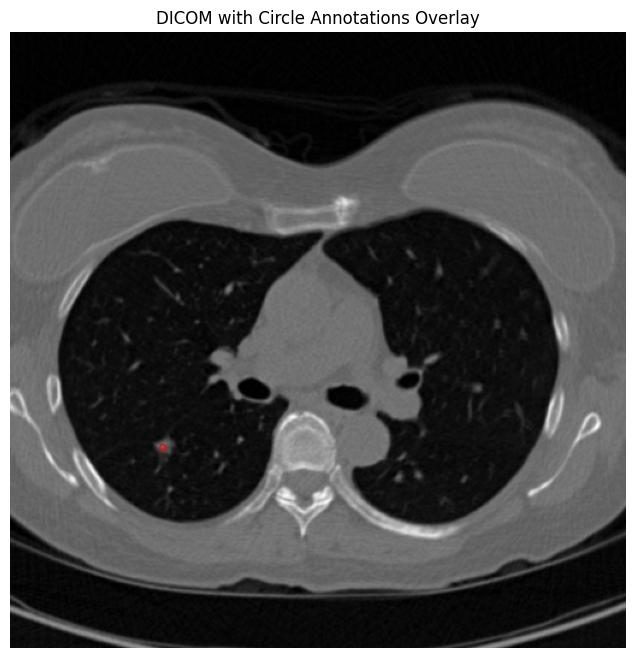

In [65]:
dicom_data = pydicom.dcmread(dicom_file)

circles = extract_circle_annotations(xml_file)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(dicom_data.pixel_array, cmap='gray')


ax.set_aspect('equal')


for center, radius in circles:
    circle = Circle(center, radius, color='r', fill=False)
    ax.add_patch(circle)


ax.axis('off')
plt.title('DICOM with Circle Annotations Overlay')
plt.show()

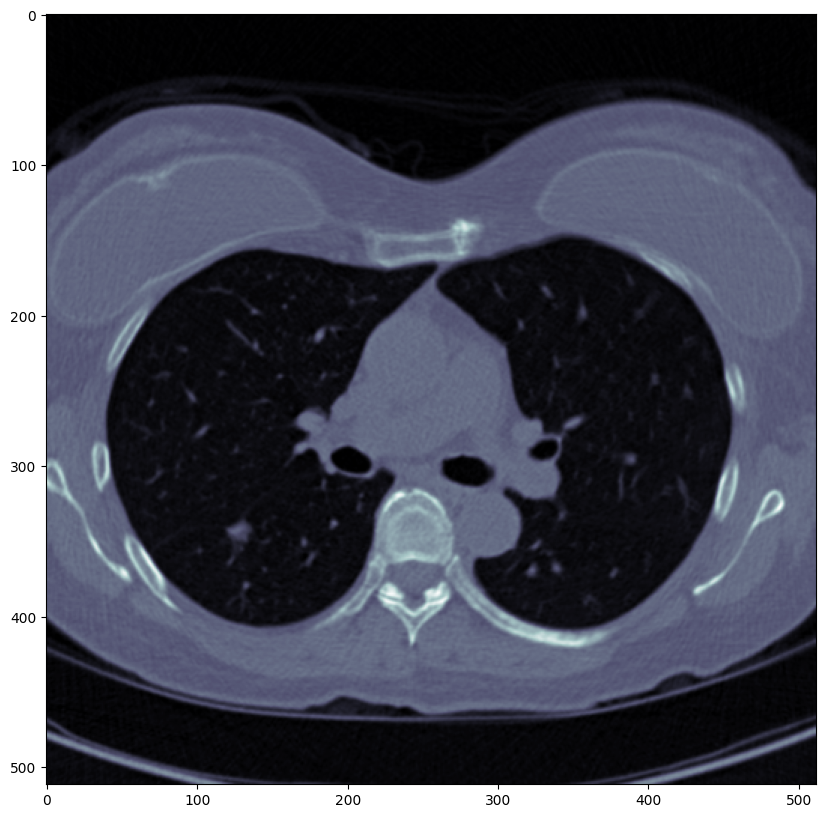

In [6]:

ds = pydicom.dcmread(dicom_file)


dicom_img_data = ds.pixel_array
plt.figure(figsize=(10,10))
plt.imshow(dicom_img_data, cmap=plt.cm.bone)
plt.show()

In [7]:
pip install pynrrd

In [8]:
import nrrd
import os

In [9]:
output_directory = 'nrrd_masks'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [62]:
dicom_data = pydicom.dcmread(dicom_file)
image_shape = dicom_data.pixel_array.shape


circle_annotations = extract_circle_annotations(xml_file)

def create_label_map(annotations, image_shape):
    label_map = np.zeros(image_shape, dtype=np.short)
    label_value = 1  # Label value for the annotated region
    for center, radius in annotations:
        rr, cc = np.ogrid[:image_shape[0], :image_shape[1]]
        circle_mask = (rr - center[1]) ** 2 + (cc - center[0]) ** 2 <= radius ** 2
        label_map[circle_mask] = label_value
        label_value += 1  # Increment label value for each new annotation
    return label_map

# Get image shape (assume it's known or predefined)
image_shape = (512, 512)  # Adjust based on your data

# Create the label map
label_map = create_label_map(circle_annotations, image_shape)

pixel_spacing = dicom_data.PixelSpacing
image_orientation = dicom_data.ImageOrientationPatient
image_position = dicom_data.ImagePositionPatient

# Construct the NRRD header
header = {
    'type': 'short',  # Adjust based on your DICOM pixel data type
    'dimension': 2,   # This is a 2D image
    'sizes': np.array([512, 512]),
    'endian': 'little',
    'encoding': 'gzip',
    'space': 'left-posterior-superior',  # Adjust based on DICOM metadata
    'space directions': np.array([
        [image_orientation[0] * pixel_spacing[0], image_orientation[1] * pixel_spacing[1]],
        [image_orientation[2] * pixel_spacing[0], image_orientation[3] * pixel_spacing[1]]
    ]),
    'kinds': ['domain', 'domain'],
    'space origin': np.array(image_position[:2])  # Assuming 2D slice, so take first two values
}


# Save the label map as an NRRD file
output_file = os.path.join(output_directory, 'label_map_2d.nrrd')
nrrd.write(output_file, label_map, header)
print(f'Saved 2D label map as {output_file}')




Saved 2D label map as nrrd_masks/label_map_2d.nrrd


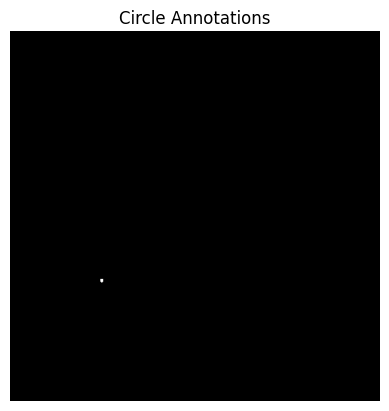

In [52]:
plt.imshow(label_map, cmap='gray')
plt.title('Circle Annotations')
plt.axis('off')
plt.show()

In [22]:
files = '3 THORAX LUNG 1MM.nrrd'
header = nrrd.read_header(files)

In [63]:
s= nrrd.read_header("/content/3 THORAX LUNG 1MM.nrrd")

In [64]:
s

OrderedDict([('type', 'short'),
             ('dimension', 3),
             ('space', 'left-posterior-superior'),
             ('sizes', array([512, 512,   1])),
             ('space directions',
              array([[0.53320312, 0.        , 0.        ],
                     [0.        , 0.53320312, 0.        ],
                     [0.        , 0.        , 1.        ]])),
             ('kinds', ['domain', 'domain', 'domain']),
             ('endian', 'little'),
             ('encoding', 'gzip'),
             ('space origin',
              array([-131.23339844, -274.73339844, -140.        ]))])

In [59]:
h=nrrd.read_header("/content/nrrd_masks/label_map_2d.nrrd")

In [60]:
h

OrderedDict([('type', 'int16'),
             ('dimension', 2),
             ('space', 'left-posterior'),
             ('sizes', array([512, 512])),
             ('space directions',
              array([[0.53320312, 0.        ],
                     [0.        , 0.        ]])),
             ('kinds', ['domain', 'domain']),
             ('endian', 'little'),
             ('encoding', 'gzip'),
             ('space origin', array([-131.23339844, -274.73339844]))])

Saved label map as nrrd_masks/label_map.nrrd


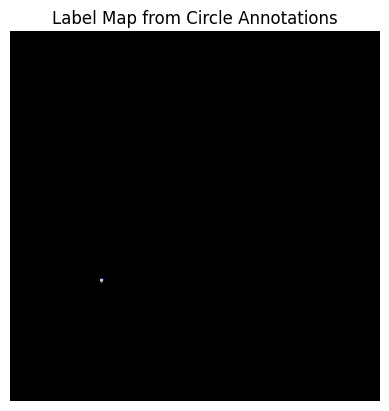

In [53]:
hi=nrrd.read_header("/content/3 THORAX LUNG 1MM.nrrd")

In [54]:
hi

OrderedDict([('type', 'short'),
             ('dimension', 3),
             ('space', 'left-posterior-superior'),
             ('sizes', array([512, 512,   1])),
             ('space directions',
              array([[0.53320312, 0.        , 0.        ],
                     [0.        , 0.53320312, 0.        ],
                     [0.        , 0.        , 1.        ]])),
             ('kinds', ['domain', 'domain', 'domain']),
             ('endian', 'little'),
             ('encoding', 'gzip'),
             ('space origin',
              array([-131.23339844, -274.73339844, -140.        ]))])

In [38]:
pip install vtk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 MB 9.5 MB/s eta 0:00:00


In [44]:
import vtk

file_path = "/content/nrrd_masks/label_map_2d.nrrd"

# Create a reader

reader = vtk.vtkNrrdReader()
try:
    reader.SetFileName("/content/nrrd_masks/label_map_2d.nrrd")
    reader.Update()
    print("hello")
except Exception as e:
    print(f"Error reading NRRD file: {str(e)}")

hello
